In [46]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np

import torch
from torch.nn.parameter import Parameter
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

from controllers import DeePC
plt.rcParams["figure.figsize"] = (15,5)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
A = np.array([[1.01, 0.01, 0.00], # A - State-space matrix
              [0.01, 1.01, 0.01], 
              [0.00, 0.01, 1.01]]) 
B = np.eye(3) # B - State-space matrix
C = np.eye(3) # C - State-space matrix
D = np.zeros([3,3]) # D - State-space matrix
n = A.shape[0] # n = number of states
m = B.shape[1] # m = number of inputs
p = C.shape[0] # p = number of output
q = m+p # q = number of i/o variables

Tini = 4                                   # Past time horizon                                           
Tf = 10                                     # Future time horizon         
T = (m+1)*(Tini + Tf + n) - 1                           

ud shape : (67, 3), yd shape : (67, 3)


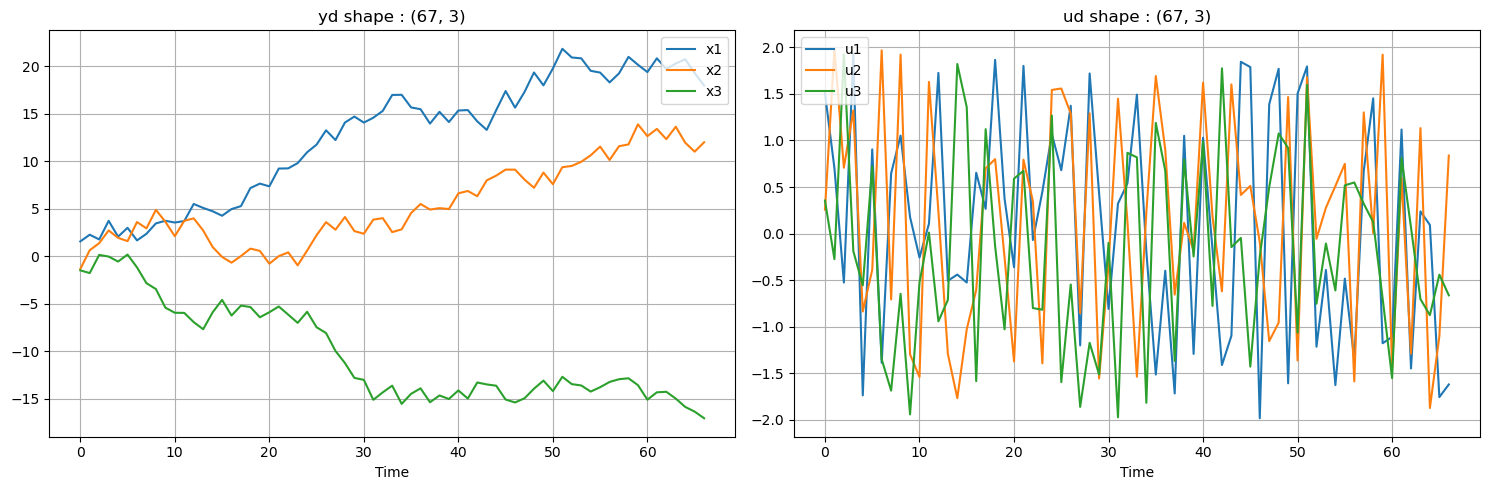

In [48]:
ud = []
yd = []
x = np.random.uniform(low=-2, high=2, size=(m,)) # Random initial condition
for i in range(T):
   u = np.random.uniform(low=-2, high=2, size=(m,)) # Random input
   x = A@x + B@u
   y = C@x + D@u
   ud.append(u)
   yd.append(y + np.random.randn(p,)*0.01) 
ud = np.array(ud)
yd = np.array(yd)

print(f'ud shape : {ud.shape}, yd shape : {yd.shape}')
plt.subplot(1,2,1)
plt.plot(range(0,T), yd, label=['x1', 'x2', 'x3'])
plt.legend(loc="upper right")
plt.xlabel('Time')
plt.title(f"yd shape : {yd.shape}")
plt.grid(True)
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(range(0,T), ud, label=['u1', 'u2', 'u3'])
plt.legend(loc="upper left")
plt.xlabel('Time')
plt.title(f"ud shape : {ud.shape}")
plt.grid(True)
plt.tight_layout()

plt.show()

ud = ud.reshape((T*m,))
yd = yd.reshape((T*p,))

In [49]:
u_ini = ud[:m*Tini].reshape((Tini*m,))
y_ini = yd[:p*Tini].reshape((Tini*p,))
y_constraints = np.kron(np.ones(Tf), np.array([10,10,10]))
u_constraonts = np.kron(np.ones(Tf), np.array([2,2,2]))
R = np.eye(m)*0.1
Q = np.eye(p)*10

controller = DeePC(
    ud=ud, yd=yd, y_constraints=y_constraints, u_constraints=u_constraonts,
    N=Tf, Tini=Tini, n=n, T=T, p=p, m=m
)

In [50]:
def imitation_loss(ref : np.array, q_est : torch.Tensor, r_est : torch.Tensor) -> torch.Tensor:

    # Expert
    controller.setup(ref=ref, Q=Q, R=R, u_ini=u_ini, y_ini=y_ini)
    _, expert_g = controller.solve(verbose=False, solver=cp.ECOS)

    # Learner
    Q_est = np.diag(q_est.detach().numpy())
    R_est = np.diag(r_est.detach().numpy())
    controller.setup(ref=ref, Q=Q_est, R=R_est, u_ini=u_ini, y_ini=y_ini)
    _, learner_g = controller.solve(verbose=False, solver=cp.ECOS)

    # Construct loss
    expert_g, learner_g = torch.Tensor(expert_g), torch.Tensor(learner_g)
    loss = torch.mean((expert_g - learner_g)**2)
    loss.requires_grad_(True)
    return loss


In [51]:
weight_est, ctrl_est = Parameter(torch.randn(size=(3,))*0.1+1), Parameter(torch.randn(size=(3,))*0.1+1)
print(f'Q = {weight_est}\nR = {ctrl_est}')

Q = Parameter containing:
tensor([1.0308, 0.9292, 0.9107], requires_grad=True)
R = Parameter containing:
tensor([1.1192, 1.1054, 1.1304], requires_grad=True)


In [53]:
opt = optim.RMSprop((weight_est, ctrl_est), lr=1e-2)
pbar = tqdm(range(100), ncols=120)

for i in pbar:
    ref = np.random.uniform(low=-2, high=2, size=(m,)) # Random reference 
    ref = np.kron(np.ones(controller.N), ref)

    loss = imitation_loss(ref, weight_est, ctrl_est)
    opt.zero_grad()
    loss.backward()
    opt.step()

    # Used to checj the difference in ratio of ctrl cost and state cost
    model_loss = np.abs(100 - weight_est.sum().item() / ctrl_est.sum().item())

    pbar.set_description(f'Loss = {loss.item():.10f}, Model Loss = {model_loss:.2f}, ref = {ref[0]:.2f},{ref[1]:.2f},{ref[2]:.2f}')


Loss = 6.2009334564, Model Loss = 99.14, ref = -0.24,-1.18,0.50: 100%|████████████████| 100/100 [00:03<00:00, 28.61it/s]


In [55]:
loss

tensor(6.2009, requires_grad=True)

In [54]:
print(f'Q = {weight_est}\nR = {ctrl_est}')

Q = Parameter containing:
tensor([1.0308, 0.9292, 0.9107], requires_grad=True)
R = Parameter containing:
tensor([1.1192, 1.1054, 1.1304], requires_grad=True)
